In [1]:
import sys
import os
import os.path as op

import glob
import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from math import pi
import xarray as xr
import datetime

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patches import Patch

# cartopy maps
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# kml read
from pykml import parser
from geopy.distance import geodesic

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import spectra, plot_spectra, wrapSpectra, plot_sat, io
from lib.config import *

# Mean wave parameres derived from the 2D wave spectra

In [2]:
# load data tracks and ww3 model output
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))

## Config SWIM parameters

In [3]:
# side of the nadir track to analyse (0 : right sides ; 1 :left side)
nadir_side = 1

# beam choice for spectra : 6=> beam 6°; 8=> beam 8°; 10=> beam 10° ; 0 => combined (combination of the 3 beams)
beam = 10

# partitions visualization : True => partitions plotted; False => partitions not plotted
partitions = True

# color bar min and max values ('None' recommended)
vmin, vmax = None, None

# wave wavelength visualization range:
# min wavelength (m), instrument specification :70m
min_wavelength = 70

# max wavelength (m), instrument specification :500m
max_wavelength = 500 


## CFOSAT spectral data

In [4]:
# SWIM L2 NetCDF file full name (first file, first box)
dsi = ds_data.isel(file=0).dropna(dim='nbox')
SWIM_L2_NC_file_name = str(dsi.file.values)
#num_box = dsi.nbox.values[316]
num_box = 316
# 50, 33: same tp opposite direcctions

# NetCDF file opening and reading
cdf = netcdf.Dataset(glob.glob(op.join(sat_cfosat,  '*', SWIM_L2_NC_file_name))[0])


In [5]:
# example nadir_side = 0 (rigth)
cell_text = spectra.partitions_info(cdf, num_box, nadir_side, beam)
cell_text

partition  SWH(m)  wavelength(m)  direction (°)
0          1   2.151     194.388000     113.823997
1          2   1.969     114.027000      66.791000
2          3   0.964      45.318001      93.386002

**Parameters initialization**

In [6]:
# Init variables
time = cdf.variables['time_spec_l2'][:]
lon = cdf.variables['lon_spec_l2'][:]
lat = cdf.variables['lat_spec_l2'][:]
K_SPECTRA = cdf.variables['k_spectra'][:]
PARTI_COMB  = cdf.variables['mask_combined'][:]
PARTI_BEAM = cdf.variables['mask'][:]
P_COMBINED = cdf.variables['p_combined'][:]                
PP_MEAN = cdf.variables['pp_mean'][:] 
N_KI    = int(32)#int(65)
N_PHI  = int(12)
N_PARTITIONS = int(3)
k_max = round(2*pi/min_wavelength,3)
k_min = round(2*pi/max_wavelength,3)

In [7]:
# Get nadir box time and coordinates
date = (t0 + datetime.timedelta(seconds=float(time[nadir_side,num_box,0]))).strftime('%Y-%m-%dT%H:%M:%S')
lon_coor, lat_coor = lon[nadir_side, num_box], lat[nadir_side, num_box]

# get dom_azi
dom_azi = cdf.variables['wave_param_part'][2,:,nadir_side,num_box,int((beam-6)/2)]
dom_wl = cdf.variables['wave_param_part'][1,:,nadir_side,num_box,int((beam-6)/2)]

# display spectrum
if beam == 0:
    beam_title='combined'
else:
    PARTI_COMB = PARTI_BEAM[:,:,:,:,:,int((beam-6)/2)]
    P_COMBINED = PP_MEAN[:,:,:,:,int((beam-6)/2)]
    beam_title = 'beam '+ str(beam)+'$\degree$'

## Model spectral data

In [9]:
date64 = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
dayYear = date64.strftime('%j')

In [10]:
# WW3 model path
files = os.listdir(op.join(ww3_spectra_proccessed, dayYear))
df_data = io.load_files(files)

In [11]:
# loc time and coordinates of Dataset
nameFile = df_data.sort_values('dates_st').loc[df_data.dates_st < date].iloc[[-1]].name.values[0]

In [12]:
model_spec = xr.open_dataset(op.join(ww3_spectra_proccessed, dayYear, nameFile))
model_spec = model_spec.isel(cell=nadir_side, row=num_box)

In [13]:
# Holtiujsen: wave density spectra ()
# sea surface wave directional variance spectral density (m2 s rad-1)

## Read MFWAM parameters

In [14]:
file2 = os.listdir(op.join(mfawm, '2021', str(int(dayYear))))[0]
mfwam_data = pd.read_csv(
    op.join(mfawm, '2021', str(int(dayYear)), file2),
    delimiter='\s+'
)

In [15]:
mfwam_sel = wrapSpectra.mfwam_info(SWIM_L2_NC_file_name, date, nadir_side, num_box, lon_coor, lat_coor)

In [16]:
mfwam_sel

DayL2  HourL2     DateMod    lat    lon  latMod  lonMod  n_box  \
990  20210521   15103  2021052103 -62.73 -86.69   -62.7   273.3    317   

     posneg   swh  ...    mwd1  mwp1  swh2    mwd2   mwp2   u10   v10  ucurr  \
990       2  3.36  ...  289.44  9.35  0.86  250.88  14.65  2.09  3.55  -0.04   

     vcurr                                             L2name  
990   0.08  CFO_OP05_SWI_L2_____F_20210521T005442_20210521...  

[1 rows x 27 columns]

In [17]:
date

'2021-05-21T01:51:03'

## Compute raw and oneSide spectra

In [18]:
# ds_Raw - 0º at the North, (0-360º)
# ['90','60','30','0','330','300','270','240','210','180','150','120'])

**Mask the partitions with no correlation in WW3 model**

In [20]:
dom_azi_pro = wrapSpectra.dir_ambiguity(dom_azi, dom_wl, mfwam_sel, lon_coor, lat_coor)

# PARTI_COMB: mask of detected partitions
parts_nan = np.where(np.isnan(dom_azi_pro.data))[0]
PARTI_COMB[:,:,parts_nan,nadir_side,num_box] = 0

In [21]:
cell_model = pd.DataFrame(
    {
        'partition':[1, 2, 3],
        'Dir': [mfwam_sel.mdww.values[0], mfwam_sel.mwd1.values[0], mfwam_sel.mwd2.values[0]],
        'Tp': [mfwam_sel.mpww.values[0], mfwam_sel.mwp1.values[0], mfwam_sel.mwp2.values[0]] 
    }
)
cell_model['Wl'] = (g*cell_model['Tp']**2)/(2*np.pi)

## Plot 2D mean slope spectrum from CFOSAT and WW3 spectral density

In [22]:
# compute origial spectra from CFOSAT
ds_Raw = spectra.rawSpectra(P_COMBINED, K_SPECTRA, dom_azi, 
                    posneg=nadir_side, 
                    box=num_box, n_k=N_KI, n_phi=N_PHI*2, 
                    n_partitions=N_PARTITIONS)

# eliminate 180º ambiguity
ds_oneSide, mask_comb_or, mask_comb = spectra.oneSide(ds_Raw, K_SPECTRA, PARTI_COMB, dom_azi,
                     posneg=nadir_side, box=num_box,
                     n_k=N_KI,
                     n_phi=N_PHI*2,
                     n_partitions=N_PARTITIONS)

In [23]:
# compute origial spectra from CFOSAT
ds_Raw_pro = spectra.rawSpectra(P_COMBINED, K_SPECTRA, dom_azi_pro, 
                    posneg=nadir_side, 
                    box=num_box, n_k=N_KI, n_phi=N_PHI*2, 
                    n_partitions=N_PARTITIONS)

# eliminate 180º ambiguity
ds_oneSide_pro, mask_comb_pro_or, mask_comb_pro = spectra.oneSide(ds_Raw_pro, K_SPECTRA, PARTI_COMB, dom_azi_pro,
                     posneg=nadir_side, box=num_box,
                     n_k=N_KI,
                     n_phi=N_PHI*2,
                     n_partitions=N_PARTITIONS)

In [24]:
wave_spec = ds_oneSide.assign_coords(lon=lon_coor, lat=lat_coor, date=date)
da_spectra = wave_spec.sum(dim='part').slopeD

wave_spec_pro = ds_oneSide_pro.assign_coords(lon=lon_coor, lat=lat_coor, date=date)
da_spectra_pro = wave_spec_pro.sum(dim='part').slopeD

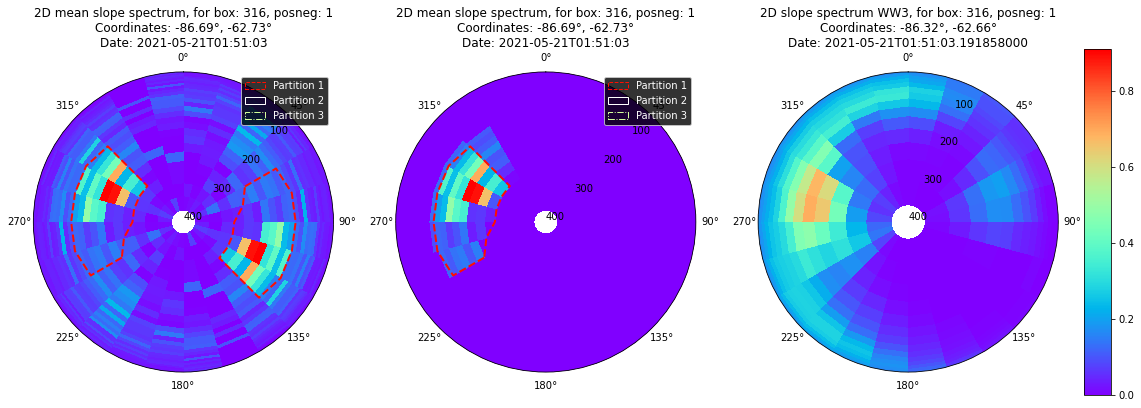

In [25]:
vmin, vmax = 0, ds_Raw_pro.data.max()
l_min, l_max = 30, 400

partitions = True
cmap = 'rainbow'

# partitions-spectra map
fig = plt.figure(figsize=(15,12), constrained_layout=True)
gs = fig.add_gridspec(1,3, wspace=0.2)
axt = fig.add_subplot(gs[0, 0], projection='polar')
axb = fig.add_subplot(gs[0, 1], projection='polar')
axc = fig.add_subplot(gs[0, 2], projection='polar')

# plot the SWIM 2D wave spectra for the selected box fig, gs, wave_spec, mask_comb, K_SPECTRA
fig, axt = plot_spectra.plotSpectra(fig, axt, ds_Raw_pro, mask_comb_or, K_SPECTRA, 
              num_box, nadir_side,
              N_PHI, l_min, l_max,
              vmin, vmax, True,
              lon_coor, lat_coor, date)

fig, axb = plot_spectra.plotSpectra(fig, axb, da_spectra_pro, mask_comb_pro, K_SPECTRA, 
                  num_box, nadir_side,
                  N_PHI, l_min, l_max,
                  vmin, vmax, partitions,
                  lon_coor, lat_coor, date)

title = '2D slope spectrum WW3, for box: ' + str(num_box) + ', posneg: '+ str(nadir_side)
suptitle = '\nCoordinates: {0:.2f}°, {1:.2f}°\nDate: {2}'.format(model_spec.lon.values, model_spec.lat.values, model_spec.time.values)
title += suptitle
    
fig, axc = plot_spectra.plotModel(fig, axc, model_spec, cmap, title, vmin, vmax, l_min, l_max)


In [26]:
sys.exit()

SystemExit: 

## Plot processed partitions

## Select sector and compute mean parameters

In [ ]:
distance, bearing, bearing_p1 = spectra.geoBearing(lon_coor, lat_coor)

# Select sector and compute mean parameters
ds_spectra = ds_oneSide.sum(dim='part')
ds_sector = ds_spectra.isel(theta=np.argmin(np.abs(ds_spectra.theta.values - bearing)))
Hs,T,C,Ttime = spectra.meanParameters(ds_sector, distance, K_SPECTRA)
    


In [ ]:
# example point
figsize=(5,5)
fig, ax = plot_sat.map_init(figsize)
ax = plot_sat.map_settings(ax)

#ax.set_extent([lon1_P-5, lon2_P+5, lat1_P-5, lat2_P+5])
ax.plot(site_lon, site_lat, markersize=7, marker='o', color='red', transform=ccrs.PlateCarree(), zorder=3, label=site)
ax.plot(lon_coor, lat_coor, markersize=7, marker='o', color='k', transform=ccrs.PlateCarree(), zorder=2, label='Observation point')
ax.plot([lon_coor, site_lon], [lat_coor, site_lat], '--', c='dimgray', transform=ccrs.Geodetic(), zorder=1)
plt.legend(loc='upper left')
ax.set_title('Distance: {0:.2f} m\n Bearing Obs: {1:.2f}º\n Bearing Samoa.: {2:.2f}º'.format(distance, bearing, bearing_p1))

plt.show()

In [ ]:
# Plot masked spectra
Hs,T,C,Ttime = spectra.meanParameters(ds_sector, distance, K_SPECTRA)
print('Hs: {0}\nT: {1}\nC: {2}\nTravel time: {3}'.format(Hs, T, C, Ttime))

In [ ]:
sector = np.argmin(np.abs(ds_spectra.theta.values - bearing))
ds_mask = ds_spectra.where(ds_spectra.theta==ds_spectra.theta.values[sector])

In [ ]:
# partitions-spectra map
fig = plt.figure(figsize=(7,7), constrained_layout=True)

fig = plot_spectra.plotSpectra(fig, ds_mask.slopeD, mask_comb, K_SPECTRA, 
                  num_box, nadir_side,
                  N_PHI, k_min, k_max,
                  vmin, vmax, partitions,
                  lon_coor, lat_coor, date)
